In [ ]:
pip install pandas scikit-learn matplotlib torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Step 2: Load dataset
from google.colab import files
import io
print("Please upload amplifier_dataset.csv")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

losses = []  # To store losses per epoch

# Step 3: Preprocessing
encoder = OneHotEncoder(sparse_output=False)
X_cat = encoder.fit_transform(df[['Config']])
X_numeric = df[['Gain', 'Vcc', 'Vout']].values
X = np.hstack([X_cat, X_numeric])

y = df[['RC', 'RE', 'RG']].values

# Scale numeric data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

data = np.hstack([X_scaled, y_scaled])
data_tensor = torch.tensor(data, dtype=torch.float32)

# Create dataloader
dataset = TensorDataset(data_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Step 4: Define VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Step 5: Train the VAE
input_dim = data.shape[1]
vae = VAE(input_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

def vae_loss(x_hat, x, mu, logvar):
    recon_loss = loss_fn(x_hat, x)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + kld

epochs = 100
vae.train()


for epoch in range(epochs):
    total_loss = 0
    for (batch,) in loader:
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(batch)
        loss = vae_loss(x_hat, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)  # Track loss here
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Step 6: Predict resistor values using user input
vae.eval()
print("\nEnter input parameters:")
user_config = input("Configuration (CE, CC, CG): ").strip().upper()
user_gain = float(input("Voltage Gain (e.g. 10 to 100): "))
user_vcc = float(input("Vcc (e.g. 5 to 20): "))
user_vout = float(input("Vout (e.g. between 1 and Vcc - 1): "))

user_cat = encoder.transform([[user_config]])
user_numeric = np.array([[user_gain, user_vcc, user_vout]])
user_x = np.hstack([user_cat, user_numeric])
user_x_scaled = scaler_x.transform(user_x)

# Fill in dummy resistor values (0s) for generation input
gen_input = np.hstack([user_x_scaled, np.zeros((1, 3))])
gen_tensor = torch.tensor(gen_input, dtype=torch.float32)

# Encode and decode through VAE
with torch.no_grad():
    mu, logvar = vae.encode(gen_tensor)
    z = vae.reparameterize(mu, logvar)
    reconstructed = vae.decode(z).numpy()

# Extract predicted resistor values (last 3 values in output)
pred_scaled = reconstructed[:, -3:]
pred_resistor = scaler_y.inverse_transform(pred_scaled)[0]

print(f"\nPredicted Resistor Values:")
print(f"RC = {pred_resistor[0]:.2f} ohms")
print(f"RE = {pred_resistor[1]:.2f} ohms")
print(f"RG = {pred_resistor[2]:.2f} ohms")


Please upload amplifier_dataset.csv


Saving amplifier_dataset_all_updated.csv to amplifier_dataset_all_updated.csv
Epoch 10, Loss: 30.3560
Epoch 20, Loss: 30.3346
Epoch 30, Loss: 30.2998
Epoch 40, Loss: 30.2903
Epoch 50, Loss: 30.2967
Epoch 60, Loss: 30.2980
Epoch 70, Loss: 30.2873
Epoch 80, Loss: 30.2754
Epoch 90, Loss: 30.2823
Epoch 100, Loss: 30.2762

Enter input parameters:
Configuration (CE, CC, CG): CE
Voltage Gain (e.g. 10 to 100): 12
Vcc (e.g. 5 to 20): 6
Vout (e.g. between 1 and Vcc - 1): 1

Predicted Resistor Values:
RC = 1316.93 ohms
RE = 31.00 ohms
RG = 10526.36 ohms


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


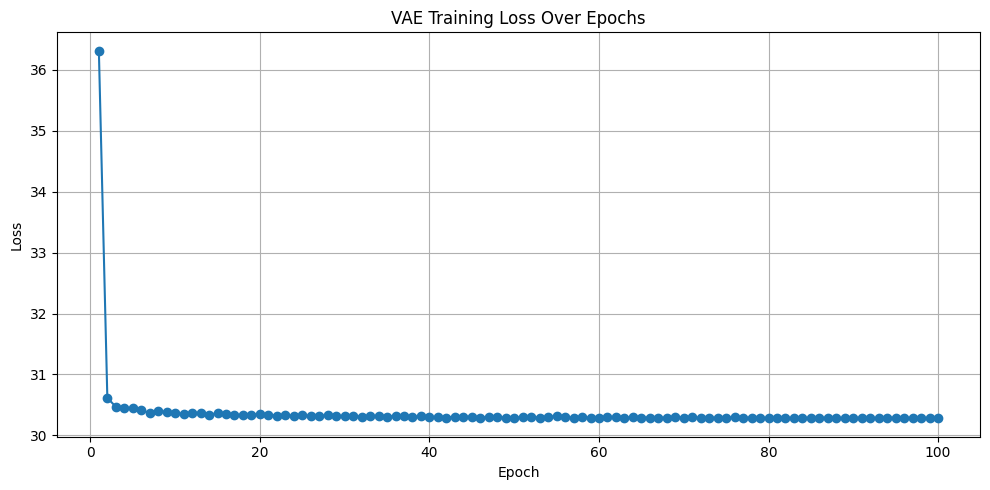

In [ ]:
# Step 7: Plot training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("VAE Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install schemdraw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.9/151.9 kB 5.1 MB/s eta 0:00:00


In [ ]:
import schemdraw
import schemdraw.elements as elm

def draw_ce_amplifier(RC, RE, RG):
    with schemdraw.Drawing() as d:
        d.config(unit=3)

        # Input side
        d += (vin := elm.SourceSin().label('Vin', 'left').reverse())
        d += (rg := elm.Resistor().right().label(f'RG = {RG:.0f}Ω'))
        d += (base := elm.Dot(open=True))


        # BJT transistor
        d.push()
        d += (q := elm.BjtNpn(circle=True).anchor('base').right().label('Q1', loc='bottom'))

        # Collector branch
        d.push()
        d += (rc := elm.Resistor().up().label(f'RC = {RC:.0f}Ω'))
        d += elm.SourceV().up().label('Vcc')
        d.pop()

        # Emitter branch
        d += elm.Line().down()
        d += (re := elm.Resistor().down().label(f'RE = {RE:.0f}Ω'))
        d += elm.Ground()

        # Output from collector
        d.pop()
        d += elm.Line().right().at(q.collector)
        d += elm.Dot()
        d += elm.Line().up()
        d += elm.Line().right()
        d += elm.SourceV().down().label('Vout', loc='right')
        d += elm.Ground()
        d.draw()

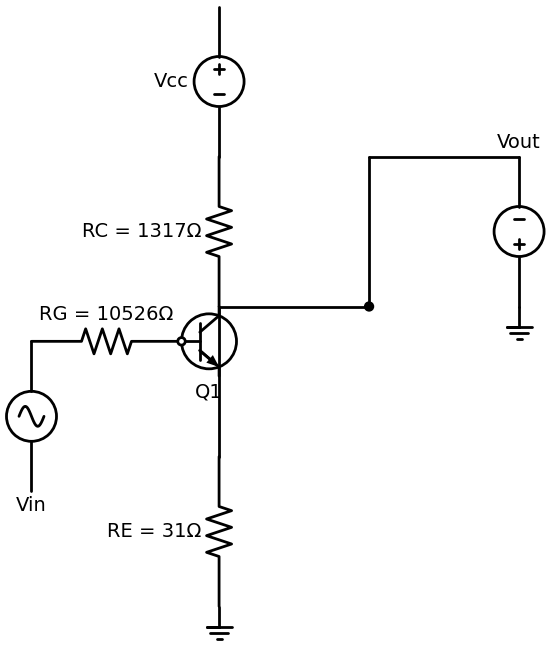

In [ ]:
draw_ce_amplifier(pred_resistor[0], pred_resistor[1], pred_resistor[2])

In [ ]:
# === New Code Cell: Performance Metrics Only ===

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_performance(y_true, y_pred):
    metrics = {}
    labels = ['RC', 'RE', 'RG']

    for i, label in enumerate(labels):
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true[:, i], y_pred[:, i])

        metrics[label] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        }

    return metrics

# Prepare true and predicted values
y_true = y  # original resistor values before scaling

vae.eval()
with torch.no_grad():
    input_for_pred = np.hstack([X_scaled, np.zeros((X_scaled.shape[0], 3))])
    input_tensor = torch.tensor(input_for_pred, dtype=torch.float32)
    mu, logvar = vae.encode(input_tensor)
    z = vae.reparameterize(mu, logvar)
    reconstructed = vae.decode(z).numpy()

pred_scaled = reconstructed[:, -3:]
pred_resistor = scaler_y.inverse_transform(pred_scaled)

# Print metrics
performance = evaluate_performance(y_true, pred_resistor)
print("Performance Metrics:")
for resistor, vals in performance.items():
    print(f"\n{resistor}:")
    for metric_name, metric_val in vals.items():
        print(f"  {metric_name}: {metric_val:.4f}")


Performance Metrics:

RC:
  MAE: 2340.8924
  MSE: 15549389.0375
  RMSE: 3943.2714
  R2: -0.0002

RE:
  MAE: 409.8819
  MSE: 851437.0830
  RMSE: 922.7335
  R2: -0.1728

RG:
  MAE: 4322.9357
  MSE: 31269773.9659
  RMSE: 5591.9383
  R2: -0.0001
